Maybe from switching models, but I got a wierd error that the trainer couldn't train.
I thought perhaps it was a Torch setting, hence below.
But it was to install `sudo apt-get install python3.11-dev`

[LESA](https://arxiv.org/abs/2101.11891) gets to the heart of the issue with using Claim Buster - it's not Social Media data. 
Per this paper, I found data - https://github.com/LCS2-IIITD/LESA-EACL-2021/blob/main/data/Twitter.csv
0 is non-claim and 1 is Claim.

Initially the dataset is not balanced, but actually has 8722 claims and 1259 non claims, so the off balance is in our favour (for once). 



# Copied because I think it's a good start

In [1]:
import os
# os.environ.update({
#     # "TORCH_COMPILE_DISABLE": "1",
#     # "PYTORCH_DISABLE_TRITON_INFERENCE": "1", 
#     # "TRITON_DISABLE_LINE_INFO": "1"
#     "TOKENIZERS_PARALLELISM": True
# })

In [2]:
from collections import Counter
import json
import sqlite3
import pandas as pd
from datasets import Dataset
from pathlib import Path
import logging
import re
import uuid

import torch
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DistilBertForSequenceClassification,
    EarlyStoppingCallback,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    pipeline
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, matthews_corrcoef, confusion_matrix, classification_report,
)
from sklearn.utils import resample, shuffle
from sklearn.utils.class_weight import compute_class_weight
from pathlib import Path
from datetime import datetime
from typing import List
from enum import Enum
import spacy
import matplotlib.pyplot as plt

import shutil
import glob

/home/ksull18/code/iu-autonomous-fact-checker/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The following is just a work in progress - but this config will help for building and testing I hope.

In [ ]:
class FileConfig:
    __FullRunContext = """denotes using the complete dataset of just a smaller portion of it for testing."""
    FullRun = True

    __MiniRunContext = """denotes using a mini dataset for testing. If FullRun is True this is ignored."""
    MiniRun = False

    __ModelVersionContext = """To keep things in order, you may set model version here."""
    ModelVersion = "v0.1.0"

    ## NOTE: currently not in use for this file
    __Percentage = """If NOT a full run, what percentage of data do we use? (Think decimal values 0 < pc < 1)"""
    Percentage = 0.1
    
    __ToBuildContext = """Do we want to build another model or run without build for testing purposes."""
    ToBuild = True

    __CustomLossFnContext = """For certain cases with class imbalance we need a custom loss function."""
    CustomLossFn = False
    
    __ChunkOverlapContext = """For the vector store, chunks are 64 words with 8 word overlap."""
    ChunkOverlap = 8

    # Don't know why an option, it's basically required.
    UsePadding = True

    BaseModelName = [
        "bert-base-uncased",
        "distilbert-base-uncased",
        "answerdotai/ModernBERT-base"
    ][1] # for distilbert uncased

    # consider T5?
    # I think ModernBert allows for 512 * 16 = 8192
    MaxTokens = 512
    Hardware = 'cuda' if torch.cuda.is_available() else 'cpu'

# class Labels(Enum)
LabelMap = Enum(
    'LabelMap', 
    [
        ('other', 0),
        ('claim', 1),
    ]
)
print(f"HARDWARE: {FileConfig.Hardware}")

HARDWARE: cuda


In [4]:
# FULL_RUN denotes using all the dataset or a small bit of it for testing the process
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

Turned out the database was 52GB of Wikipedia articles, but the dataset fit OK in one file so chunking wasn't necessary...
Keeping the logic though.

## HELPERS

In [5]:
# May need to update based on use case in future (If I copy this file for any other model)
def data_transform(text: str):
    """
    This will be used later when we need to actually use this model.
    """
    # Update for BERT Specific
    return f"[CLS] {text} [SEP]"
    # return f"CLAIM: {claim} EVIDENCE: {evidence_text}"

In [6]:
def train_test_valid_split(df: pd.DataFrame, col: str, pc: float = 0.1):
    assert pc < 1 and pc > 0

    x_all = df.drop(col, axis=1)
    y_all = df[col]
    lth_all = len(x_all)
    tenpc = int(len(x_all) * 0.1)
    x_test, x_tmp, y_test, y_tmp = train_test_split(
        x_all, y_all,
        test_size=(len(x_all) - tenpc),
        stratify=y_all,
        random_state=42,
    )

    x_val, x_train, y_val, y_train = train_test_split(
        x_tmp, y_tmp,
        test_size=(len(x_tmp) - tenpc),
        stratify=y_tmp,
        random_state=42,
    )

    # Train for training
    pdft = x_train.copy()
    pdft['label'] = y_train.values

    # Dev for testing
    pdfd = x_test.copy()
    pdfd['label'] = y_test.values

    # Validation for validation
    pdfv = x_val.copy()
    pdfv['label'] = y_val.values

    return pdft, pdfd, pdfv

In [7]:
def reverse_tweettopic_preprocessing(text):
    """
    Convert TweetTopic format back to regular @mentions
    """
    # Convert {@username@} back to @username
    text = re.sub(r'\{@([^@}]+)@\}', r'{{USERNAME}}', text)
    
    return text

# Example
tweettopic_text = "Thanks to {@KEVIN123456789@} and {{USERNAME}} for the AI MODEL! {{URL}}"
restored_text = reverse_tweettopic_preprocessing(tweettopic_text)
print(restored_text)

def standardize_preprocessing(text):
    """
    Standard preprocessing for both TweetTopic and your political data
    """
    # First, reverse any existing TweetTopic formatting
    # This was specific to another dataset - but just in case - we keep it here.
    text = reverse_tweettopic_preprocessing(text)
    
    # Then apply consistent preprocessing
    # Replace URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '{{URL}}', text)
    
    # Replace all @mentions with {{USERNAME}}
    text = re.sub(r'@\w+', '{{USERNAME}}', text)
    
    return text


Thanks to {{USERNAME}} and {{USERNAME}} for the AI MODEL! {{URL}}


## Loading Data

I've vectorized the evidence best I can so it matches the inputs it will receive.

In [57]:
class LESAData:
    Properties = {
        "parquet_data_path": "File path to the Parquet file of data",
        "rawdf": "dataframe read right from file pulled from https://github.com/LCS2-IIITD/LESA-EACL-2021/blob/main/data/Twitter.csv",
        "update": "Combined the Lesa dataset with Sentiment140"
    }
    LabelMap = {
        "OTHER": 0,
        "CLAIM": 1
    }
    def __init__(self):
        here = Path().cwd()
        datadirpath = here / ".data_sets" / "lesa"
        datadirpath.mkdir(exist_ok=True)
        # self.parquet_data_path = datadirpath / "lesa_set.parquet"
        self.parquet_data_path = datadirpath / "lesa_sent140_set.parquet"
        if not self.parquet_data_path.exists():
            csvpath = here / ".data_sets" / "Twitter.csv"
            assert csvpath.exists()
            pd.read_csv(csvpath, encoding='utf-8').to_parquet(self.parquet_data_path)
            assert self.parquet_data_path.exists()
        self.rawdf = pd.read_parquet(self.parquet_data_path)
        self.df = None
        # Training / Coaching
        self.dft = None
        # Testing / Evaluation
        self.dfe = None
        # Validation
        self.dfv = None
    
    def view_data(self):
        dfv: pd.DataFrame = self.rawdf if self.df is None else self.df
        title_data = {
            "INFO": dfv.info(),
            "COLUMNS": dfv.columns,
            "DESCRIPTION": dfv.describe(),
            "CLAIMS": dfv['label'].value_counts(),
            "TOP TEN": dfv.head(10)
        }

        for title, data in title_data.items():
            print("-" * 50)
            print(f"{title}:")
            print(data)
            print()
    
    def clean_data(self):
        dfd: pd.DataFrame = self.rawdf if self.df is None else self.df
        # dfd['text'] = dfd.apply(lambda x: standardize_preprocessing(x['tweet_text']), axis=1)
        dfd['cleantext'] = dfd.apply(lambda x: standardize_preprocessing(x['text']), axis=1)
        # dfd['label'] = dfd['claim']
        self.df = dfd
        print("Data Cleaned")
        print(self.df.head())
        print(self.df['label'].value_counts())
        print()

    # THIS IS LIKE A USE ONCE THING
    def bad_balance(self):
        dfr: pd.DataFrame = self.rawdf if self.df is None else self.df
        dfo = dfr[dfr['claim'] == 0]
        dfc = dfr[dfr['claim'] == 1]
        if len(dfc) > len(dfo):
            dfc = dfc.sample(n=len(dfo), replace=False, ignore_index=False)
        else:
            dfo = dfo.sample(n=len(dfo), replace=False, ignore_index=False)
        self.df = pd.concat([dfc,dfo])

    def better_balance(self):
        dfr: pd.DataFrame = self.rawdf if self.df is None else self.df
        dfo = dfr[dfr['label'] == 'other']
        dfc = dfr[dfr['label'] == 'claim']
        if len(dfc) > len(dfo):
            print("Claims bigger than Other")
            dfc = dfc.sample(n=len(dfo), replace=False, ignore_index=False)
        else:
            print("Other bigger than Claims")
            dfo = dfo.sample(n=len(dfc), replace=False, ignore_index=False)
        self.df = pd.concat([dfc,dfo])
        print("Data balanced")
        print(self.df.head())
        print(self.df['label'].value_counts())
        print()
    
    
    def split_data(self):
        df: pd.DataFrame = self.rawdf if self.df is None else self.df
        dft, dfe, dfv = train_test_valid_split(df, 'label')
        # dft, dfe, dfv = train_test_valid_split(df, 'claim')
        self.dft = dft
        self.dfe = dfe
        self.dfv = dfv


In [58]:
lesa = LESAData()

In [59]:
lesa.view_data()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19981 entries, 0 to 19980
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   19981 non-null  object
 1   text    19981 non-null  object
dtypes: object(2)
memory usage: 312.3+ KB
--------------------------------------------------
INFO:
None

--------------------------------------------------
COLUMNS:
Index(['label', 'text'], dtype='object')

--------------------------------------------------
DESCRIPTION:
        label       text
count   19981      19981
unique      2      19980
top     other  headache 
freq    11259          2

--------------------------------------------------
CLAIMS:
label
other    11259
claim     8722
Name: count, dtype: int64

--------------------------------------------------
TOP TEN:
   label                                               text
0  other  @FoxyUK oooo wiii i do have one of those wii f...
1  other                                     It w

In [61]:
lesa.clean_data()
# lesa.bad_balance()
lesa.better_balance()
lesa.view_data()

Data Cleaned
    label                                               text  \
6   claim  Is it too deep a thought to consider that if #...   
7   claim  BREAKING NEWS: Parody account turning hopes in...   
8   claim  RT @ricanqueeen: If you’ve ever had a senior s...   
11  claim  @TheyCallMeTomO1 If made in China, I would not...   
14  claim  A knife hidden in a baguette is the most Frenc...   

                                            cleantext  
6   Is it too deep a thought to consider that if #...  
7   BREAKING NEWS: Parody account turning hopes in...  
8   RT {{USERNAME}}: If you’ve ever had a senior s...  
11  {{USERNAME}} If made in China, I would not get...  
14  A knife hidden in a baguette is the most Frenc...  
label
claim    8722
other    8722
Name: count, dtype: int64

Other bigger than Claims
Data balanced
    label                                               text  \
6   claim  Is it too deep a thought to consider that if #...   
7   claim  BREAKING NEWS: Parody accou

In [62]:
lesa.split_data()

In [63]:
# Switch to LESA
if True:
    pdft = lesa.dft
    pdfd = lesa.dfe
    pdfv = lesa.dfv

# Model Training

Going to follow pretty close to how I trained the claim extractor / detector model.
Going to finetune BERT first I think as the context might not be big enough in DistilBERT for the evidence.

## Data Preparation

I saved the entire evidence in the 'vector_evidence' so not to lose something and need to recreate datasets... again.
However, now we must update our 'evidence' column here... 
Don't overwrite any files!

In [64]:
pdft.head()

,text,cleantext,label
6502,@OEboca DUH it says so in your twitter @OEboca...,{{USERNAME}} DUH it says so in your twitter {{...,other
14167,"@MissKatiePrice shame about u and pete, i hope...","{{USERNAME}} shame about u and pete, i hope u ...",other
9348,@Detig but I want it NOW,{{USERNAME}} but I want it NOW,other
10303,"Thank you for your donation, Judith!!!!!!!!!! ...","Thank you for your donation, Judith!!!!!!!!!! ...",other
6619,ok soo my lyf is going really down hill NOT g...,ok soo my lyf is going really down hill NOT g...,other


In [65]:
pdft['label'].value_counts()

label
other    6978
claim    6978
Name: count, dtype: int64

In [66]:
pdfd.head()

,text,cleantext,label
16808,@Khyatijparmar1 Khyati ji .. it is a bioweapon...,{{USERNAME}} Khyati ji .. it is a bioweapon . ...,claim
10190,"@matr77 I cared last week, broadband down for ...","{{USERNAME}} I cared last week, broadband down...",other
13584,stan galih to be immune to coronavirus,stan galih to be immune to coronavirus,claim
2090,Got Woke Up At 3:15am ..Who The Hay Is Making ...,Got Woke Up At 3:15am ..Who The Hay Is Making ...,other
16009,wallpaper idea! woohoo! no time... boohoo. ma...,wallpaper idea! woohoo! no time... boohoo. ma...,other


In [67]:
pdfv.head()

,text,cleantext,label
17521,Watched this nonsense today been avoiding had ...,Watched this nonsense today been avoiding had ...,claim
12988,"THREAD: On #Coronavirus, we may be entering a ...","THREAD: On #Coronavirus, we may be entering a ...",claim
328,these are the world cup 2022 workers quarantin...,these are the world cup 2022 workers quarantin...,claim
7066,It's official: we signed the lease on a new pl...,It's official: we signed the lease on a new pl...,other
14359,Trump states Ingesting Lysol may help prevent ...,Trump states Ingesting Lysol may help prevent ...,claim


In [68]:
# Data Shuffle
for _ in range(3):
    pdft = pdft.sample(frac=1, replace=False, ignore_index=True)
    pdfd = pdfd.sample(frac=1, replace=False, ignore_index=True)
    pdfv = pdfv.sample(frac=1, replace=False, ignore_index=True)

## Loading and Setup with BERT

### Initialize Tokenizer and Model

In [69]:
# Loading tokenizer for this model
tokenizer = AutoTokenizer.from_pretrained(FileConfig.BaseModelName)
# dir(tokenizer)

In [70]:
# Ran into tokenization issue - All tensors in a batch should be same length
# Some were 100 and but one was 187.
# Use padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [71]:
model = DistilBertForSequenceClassification.from_pretrained(
    FileConfig.BaseModelName, 
    num_labels=2,  # Either political or not
)
model.to(FileConfig.Hardware)

print(f"Model loaded: {FileConfig.BaseModelName}")
print(f"Vocabulary size: {tokenizer.vocab_size}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: distilbert-base-uncased
Vocabulary size: 30522


### Tokenize Data

Claim extractor / detector model has label of "Claim" or "Not Claim". 

Loading tokenizer: distilbert-base-uncased
Analyzing 13956 texts...
Processed 1000 texts...
Processed 2000 texts...
Processed 3000 texts...
Processed 4000 texts...
Processed 5000 texts...
Processed 6000 texts...
Processed 7000 texts...
Processed 8000 texts...
Processed 9000 texts...
Processed 10000 texts...
Processed 11000 texts...
Processed 12000 texts...
Processed 13000 texts...
Processed 13956 texts...

TOKEN LENGTH STATISTICS
Total samples: 13,956
Average length: 39.7 tokens
Median length: 36.0 tokens
Standard deviation: 20.3
Min length: 5 tokens
Max length: 153 tokens

PERCENTILES:
25th percentile: 24.0 tokens
50th percentile: 36.0 tokens
75th percentile: 51.0 tokens
90th percentile: 71.0 tokens
95th percentile: 79.0 tokens
99th percentile: 95.0 tokens

RECOMMENDATIONS:
  Recommended max_length: 256 (covers 95% of data)

Data truncated at different max_lengths:
  max_length=256: 0.0% truncated
  max_length=512: 0.0% truncated
  max_length=768: 0.0% truncated
  max_length=1024: 0.0

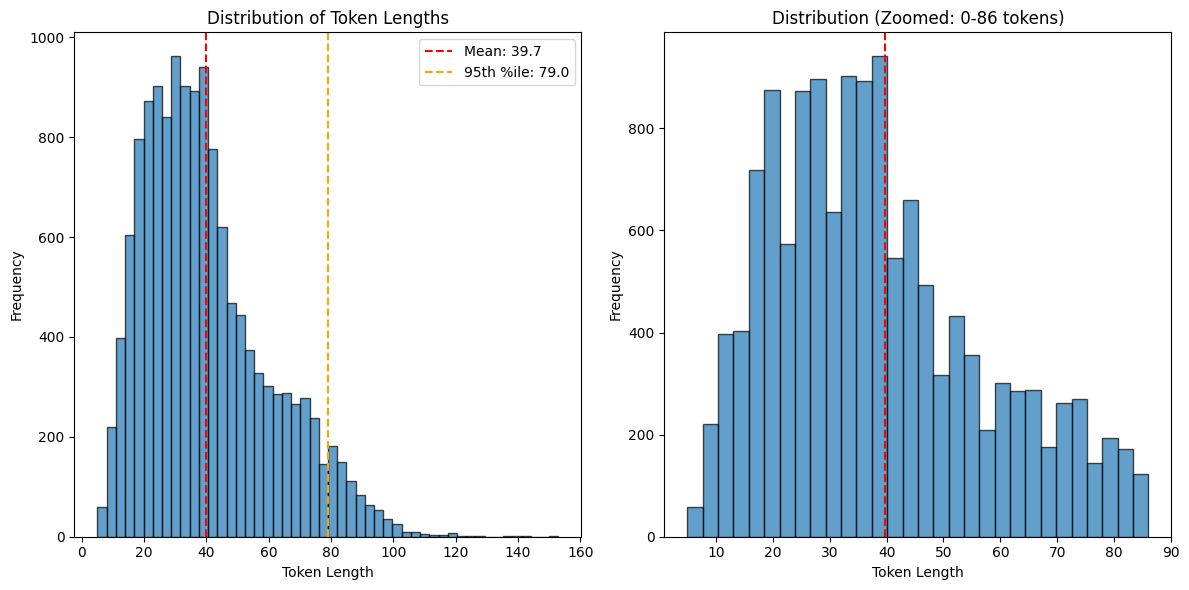

Loading tokenizer: distilbert-base-uncased
Analyzing 1744 texts...
Processed 1000 texts...

TOKEN LENGTH STATISTICS
Total samples: 1,744
Average length: 38.8 tokens
Median length: 35.0 tokens
Standard deviation: 19.7
Min length: 5 tokens
Max length: 145 tokens

PERCENTILES:
25th percentile: 24.0 tokens
50th percentile: 35.0 tokens
75th percentile: 49.0 tokens
90th percentile: 68.0 tokens
95th percentile: 77.0 tokens
99th percentile: 94.0 tokens

RECOMMENDATIONS:
  Recommended max_length: 256 (covers 95% of data)

Data truncated at different max_lengths:
  max_length=256: 0.0% truncated
  max_length=512: 0.0% truncated
  max_length=768: 0.0% truncated
  max_length=1024: 0.0% truncated
  max_length=2048: 0.0% truncated


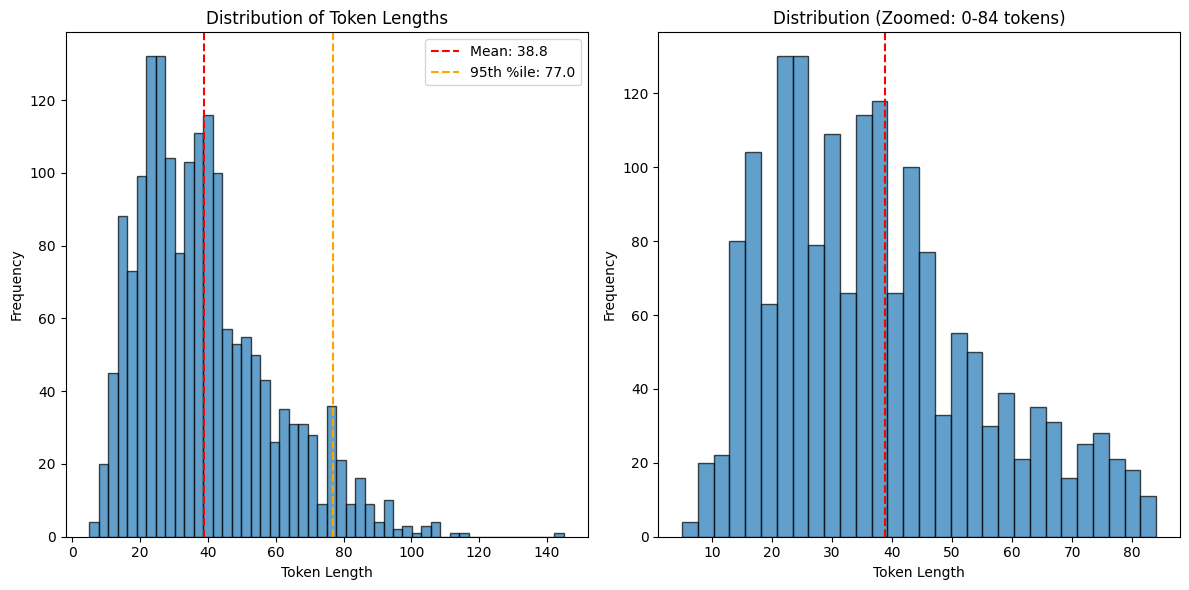

Loading tokenizer: distilbert-base-uncased
Analyzing 1744 texts...
Processed 1000 texts...

TOKEN LENGTH STATISTICS
Total samples: 1,744
Average length: 38.6 tokens
Median length: 35.0 tokens
Standard deviation: 20.1
Min length: 6 tokens
Max length: 120 tokens

PERCENTILES:
25th percentile: 23.0 tokens
50th percentile: 35.0 tokens
75th percentile: 49.0 tokens
90th percentile: 68.0 tokens
95th percentile: 78.0 tokens
99th percentile: 92.6 tokens

RECOMMENDATIONS:
  Recommended max_length: 256 (covers 95% of data)

Data truncated at different max_lengths:
  max_length=256: 0.0% truncated
  max_length=512: 0.0% truncated
  max_length=768: 0.0% truncated
  max_length=1024: 0.0% truncated
  max_length=2048: 0.0% truncated


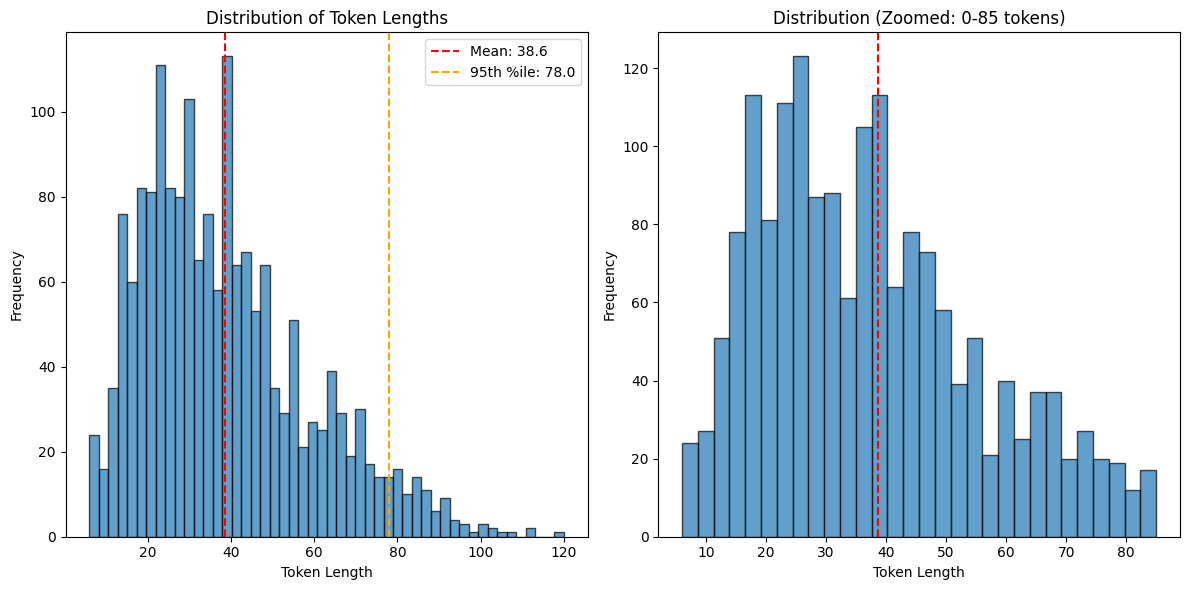

In [72]:
# Find good max token length...
def analyze_token_lengths(df, text_column='text', tokenizer_name='answerdotai/ModernBERT-base'):
    """
    Analyze token lengths in your dataset
    
    Args:
        df: pandas DataFrame
        text_column: name of column containing text
        tokenizer_name: HuggingFace tokenizer to use
    """
    
    # Load tokenizer
    print(f"Loading tokenizer: {tokenizer_name}")
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    # Get all texts
    texts = df[text_column].tolist()
    print(f"Analyzing {len(texts)} texts...")
    
    # Tokenize without truncation to get true lengths
    token_lengths = []
    
    # Process in batches for efficiency
    batch_size = 100
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenize batch
        tokenized = tokenizer(
            batch_texts, 
            truncation=False,  # Don't truncate - we want true lengths
            padding=False,     # Don't pad
            return_tensors=None
        )
        
        # Get lengths
        batch_lengths = [len(tokens) for tokens in tokenized['input_ids']]
        token_lengths.extend(batch_lengths)
        
        if (i // batch_size + 1) % 10 == 0:
            print(f"Processed {i + len(batch_texts)} texts...")
    
    # Calculate statistics
    token_lengths = np.array(token_lengths)
    
    stats = {
        'count': len(token_lengths),
        'mean': np.mean(token_lengths),
        'median': np.median(token_lengths),
        'std': np.std(token_lengths),
        'min': np.min(token_lengths),
        'max': np.max(token_lengths),
        '25th_percentile': np.percentile(token_lengths, 25),
        '50th_percentile': np.percentile(token_lengths, 50),
        '75th_percentile': np.percentile(token_lengths, 75),
        '90th_percentile': np.percentile(token_lengths, 90),
        '95th_percentile': np.percentile(token_lengths, 95),
        '99th_percentile': np.percentile(token_lengths, 99)
    }
    
    # Print results
    print("\n" + "="*50)
    print("TOKEN LENGTH STATISTICS")
    print("="*50)
    print(f"Total samples: {stats['count']:,}")
    print(f"Average length: {stats['mean']:.1f} tokens")
    print(f"Median length: {stats['median']:.1f} tokens")
    print(f"Standard deviation: {stats['std']:.1f}")
    print(f"Min length: {stats['min']} tokens")
    print(f"Max length: {stats['max']:,} tokens")
    print()
    print("PERCENTILES:")
    print(f"25th percentile: {stats['25th_percentile']:.1f} tokens")
    print(f"50th percentile: {stats['50th_percentile']:.1f} tokens")
    print(f"75th percentile: {stats['75th_percentile']:.1f} tokens")
    print(f"90th percentile: {stats['90th_percentile']:.1f} tokens")
    print(f"95th percentile: {stats['95th_percentile']:.1f} tokens")
    print(f"99th percentile: {stats['99th_percentile']:.1f} tokens")
    
    # Recommendations based on percentiles
    print("\n" + "="*50)
    print("RECOMMENDATIONS:")
    print("="*50)
    
    if stats['95th_percentile'] <= 256:
        print("  Recommended max_length: 256 (covers 95% of data)")
    elif stats['95th_percentile'] <= 512:
        print("  Recommended max_length: 512 (covers 95% of data)")
    elif stats['90th_percentile'] <= 512:
        print("️!  Consider max_length: 512 (covers 90% of data)")
        print(f"   Note: {100-90:.1f}% of samples will be truncated")
    elif stats['95th_percentile'] <= 1024:
        print("  Recommended max_length: 1024 (covers 95% of data)")
    else:
        print(f"  Consider max_length: {int(stats['95th_percentile'])} (covers 95% of data)")
        print("   Or use 1024 if you want faster training with some truncation")
    
    print(f"\nData truncated at different max_lengths:")
    for max_len in [256, 512, 768, 1024, 2048]:
        pct_truncated = (token_lengths > max_len).mean() * 100
        print(f"  max_length={max_len}: {pct_truncated:.1f}% truncated")
    
    # Create histogram
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(token_lengths, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
    plt.title('Distribution of Token Lengths')
    plt.axvline(stats['mean'], color='red', linestyle='--', label=f'Mean: {stats["mean"]:.1f}')
    plt.axvline(stats['95th_percentile'], color='orange', linestyle='--', label=f'95th %ile: {stats["95th_percentile"]:.1f}')
    plt.legend()
    
    # Zoomed in view (up to 95th percentile)
    plt.subplot(1, 2, 2)
    zoom_limit = min(int(stats['95th_percentile'] * 1.1), stats['max'])
    zoom_data = token_lengths[token_lengths <= zoom_limit]
    plt.hist(zoom_data, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
    plt.title(f'Distribution (Zoomed: 0-{zoom_limit} tokens)')
    plt.axvline(stats['mean'], color='red', linestyle='--', label=f'Mean: {stats["mean"]:.1f}')
    
    plt.tight_layout()
    plt.show()
    
    return stats, token_lengths

pdft.head(2)
pdft['input'] = pdft.apply(lambda x: data_transform(x['cleantext']), axis=1)
pdfd['input'] = pdfd.apply(lambda x: data_transform(x['cleantext']), axis=1)
pdfv['input'] = pdfv.apply(lambda x: data_transform(x['cleantext']), axis=1)

statst, token_lengthst = analyze_token_lengths(pdft, text_column='input', tokenizer_name=FileConfig.BaseModelName)
statsd, token_lengthsd = analyze_token_lengths(pdfd, text_column='input', tokenizer_name=FileConfig.BaseModelName)
statsv, token_lengthsv = analyze_token_lengths(pdfv, text_column='input', tokenizer_name=FileConfig.BaseModelName)

> Perhaps a point of improvement - better input and separation of claims and evidence. 

In [73]:
max_token_len = getattr(tokenizer, 'model_max_length', 512)
max_token_len = min(FileConfig.MaxTokens, max_token_len)
print(max_token_len)
# 512 is returned for distilbert which is more than plenty for these text inputs

512


In [ ]:
def tokenize_fn(dataset):
    # Combine claim and evidence into single text input
    texts = [t for t in dataset['input']]
    
    # Token Length calculated outside - impure but only once

    model_inputs = tokenizer(
        texts,
        truncation=True,
        padding=FileConfig.UsePadding,
        max_length=max_token_len,
    )

    # LESA 0 = Other ; 1 = Claim
    # label_map = {"political": 0, "other": 1} 
    # For LESA - Already 0 and 1
    model_inputs["label"] = [0 if x == 'other' else 1 for x in dataset['label']]

    return model_inputs

### Constant...

LABELS is for computing class weights later...

In [75]:
pdft.columns

Index(['text', 'cleantext', 'label', 'input'], dtype='object')

In [ ]:
LABELS = pdft['label'].values
LABELS

array(['other', 'claim', 'other', ..., 'claim', 'claim', 'other'],
      shape=(13956,), dtype=object)

In [77]:
min(pdft['label'].value_counts())

6978

[This StackOverflow post](https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows) lists several ways to shuffle a dataframe. 
Pandas has the builtin `df = df.sample(frac=1).reset_index(drop=True)` which apparently reassigns but does not recreate.
SciKit Learn also has a "shuffle" method but that might require resetting indexes.
There are then seemingly countless ways after that as well...

Side note on sample - it now has an 'ignore_index' param to help with that reset issue.

In [ ]:
# Convert pandas DataFrames to HF Dataset objects
if FileConfig.FullRun:
    print("Full Run!")
    print(pdft[['input', 'label']].head())
    print(pdfd[['input', 'label']].head())
    dst = Dataset.from_pandas(pdft[['input', 'label']])
    dsv = Dataset.from_pandas(pdfd[['input', 'label']])
elif FileConfig.MiniRun:
    print("Mini Run!")
    print("Copied from the Judge Model - Not implemented for claim detector")
else:
    # This is not ready yet
    print("Copied from the Judge Model - Not implemented for claim detector")

# Apply tokenization
train_dataset = dst.map(
    tokenize_fn, 
    batched=True,
    remove_columns=dst.column_names,
)
val_dataset = dsv.map(
    tokenize_fn, 
    batched=True,
    remove_columns=dsv.column_names,
)

print("Data tokenized successfully!")

Full Run!
                                               input  label
0  [CLS] I really wish I somehow space traveled w...  other
1  [CLS] {{USERNAME}} {{USERNAME}} {{USERNAME}} #...  claim
2  [CLS] {{USERNAME}} oh my! sounds good..ahem..h...  other
3  [CLS] China is being sued for $20Trillion for ...  claim
4  [CLS] {{USERNAME}} I've been stopped and warne...  other
                                               input  label
0  [CLS] Sad to hear the Silver Slipper closed  [...  other
1  [CLS] {{USERNAME}} Medical Management of #COVI...  claim
2     [CLS] {{USERNAME}} naaah don't think so  [SEP]  other
3  [CLS] This is unscientific and it may or may n...  claim
4  [CLS] My puppy Junior is not a puppy anymore  ...  other


Map:   0%|          | 0/13956 [00:00<?, ? examples/s]

Map: 100%|██████████| 1744/1744 [00:00<00:00, 20453.15 examples/s]

Data tokenized successfully!


In [79]:
dst.column_names

['input', 'label']

In [80]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.6


## Fine-Tune the Model

We are doing **transfer learning** with **fine-tuning**. 
BERT was pre-trained to understand language - Thank you!
We fine-tuning the model for a specific task - claim vs opinion here.
The technique = Supervised learning with backpropagation

Deep dive: BERT has millions of weights to understand language. We are adjusting these to suit our classification task. Only our final classification layer is learning from scratch. The rest of BERT is merely adapting instead of being completely retrained. 
BERT (I think) expects a "[MASK]" token to predict values. 
By fine-tuning, we add a layer like: `input text -> BERT Encoder -> Classification Head -> [Claim, Opinion] probabilities`.

### Defining Training Arguments

> I am taking most of this from the claim_extractor I made previously

In [81]:
# Set up directories for saving
datenow = datetime.now()
timestamp = datenow.strftime("%Y%m%d%H%M%S")

# TODO: Give model name at top
move_path = Path().cwd() / "trainingresults" / f'hide-distilbert_{timestamp}'
out_path = Path().cwd() / "trainingresults" / "latest"
metatdata_file_path = out_path / "metadata.json"

# Below is the logic for moving previous versions
if FileConfig.ToBuild:
    if metatdata_file_path.exists():
        # A model exists in latest already - move to it's timestamp

        try:
            with open(metatdata_file_path, 'r') as file:
                tmp = json.load(file)
                str_path = tmp.get('path', None)
                assert str_path is not None
                ts_path = Path(str_path)
                # Moving the old model into its timestamp directory
                out_path.rename(ts_path)
        except Exception as e:
            logger.warning(e)
            # suggests something in directory didn't finish and should probably be deleted?
        assert not out_path.exists()

    ## Open cannot make the directories after I rename them...
    out_path.mkdir(parents=True, exist_ok=True)

    with open(out_path / "metadata.json", 'w') as file:
        json.dump({"path": str(move_path), "foundation": FileConfig.BaseModelName, 'timestamp': datenow.isoformat(), "version": FileConfig.ModelVersion}, file, indent=2)

In [ ]:
# Parameters last modified 2025-08-24
training_args = TrainingArguments(
    output_dir=out_path, # Working directory during training for logs and checkpoints.
    num_train_epochs=2 if FileConfig.FullRun else 1, # Started with 3 - cuts out around 2 with end-early setting
    ## batch size of 4 works best on my RTX 3060 for now
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500 if FileConfig.FullRun else 50, # gradually increase learning rate over 500 steps | prevents huge descrutive changes early on
    learning_rate=5e-5, # Default is 5e-5 I believe
    weight_decay=0.01, # Very mild 1% to prevent memorizing training data exactly. 
    logging_dir='./logs',
    ## had set to 10 which is a lot of overhead
    logging_steps=100, # Be aware of overhead of logging
    eval_strategy="steps",
    eval_steps=500 if FileConfig.FullRun else 100,
    save_strategy="steps",
    save_steps=500 if FileConfig.FullRun else 100,
    load_best_model_at_end=True,
    metric_for_best_model="f1", # Changing for balanced data
    greater_is_better=True, # updated - for the F1 score
    dataloader_pin_memory=False, # can help with GPU transfer speed - Seems to work
    fp16=True, # mixed precision can speedup training (if supported) - Seems to work
    dataloader_num_workers=4, # parallel data loading
    #overfitting - updates
    # early_stopping_patience=2,
    save_total_limit=3,
    report_to=None,
)

### Define Evaluation Metrics

SciKit Learn has some handy prebuilt functions.

In [83]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    probabilities = predictions[:, 1] # of positive class
    predictions = np.argmax(predictions, axis=1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    accuracy = accuracy_score(labels, predictions)
    roc_auc = roc_auc_score(labels, probabilities)
    mcc = matthews_corrcoef(labels, predictions)
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'mcc': mcc,
        'true_positives': tp,
        'false_positives': fp,
        'true_negatives': tn,
        'false_negatives': fn
   }

### Custome Weights

The data is quite unbalanced.
There is a total of 48,205 entries:
- supports = 31,811
- refutes = 14,610
- na = 1,784

Rebalancing to the tiny amount is not desireable.
The `Trainer` can take in a loss function. The signature is just 'Callable' so inside the class it takes in `(outputs, labels, num_items_in_batch)`.

There are several loss functions to consider:
- 


[SciKit-Learn's `compute_class_weight`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) function follows the inverse frequency approach.

In [84]:
for I,J in enumerate(LabelMap):
    print(I)
    print(str(J))


0
LabelMap.other
1
LabelMap.claim


In [85]:
# def create_weights(labels):
#     unique_labels = np.unique(labels)
#     weights_balanced = compute_class_weight('balanced', classes=unique_labels, y=labels)
#     weight_tensor = torch.zeros(3)

#     for index, en in enumerate(LabelMap):
#         # Labels are 0 and 1 in this specific case
#         # label_inx = np.where(unique_labels == en.name)[0][0]
#         label_inx = np.where(unique_labels == en.value)[0][0]
#         weight_tensor[index] = weights_balanced[label_inx]
    
#     return weight_tensor

# class_weights = create_weights(LABELS)
# class_weights = class_weights.to(model.device)
# print(class_weights)

# # This needs work, I don't think weights should change nor be calucated during each batch...
# def custom_weighted_loss_fn(outputs, labels, num_items_in_batch=None):
#     logits = outputs.logits # Model's raw predictions [batch_size, 3]

#     # Method 1: Balanced - Inverse Frequency
#     loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
#     # This is impure function for now
#     loss = loss_fn(logits, labels)
#     return loss
    

### Initialize and Train!

In [86]:
print(len(train_dataset))
print(len(val_dataset))

13956
1744


Randomly getting error: trying `sudo apt-get install build-essential`
NO
did `sudo apt-get install python3.11-dev`

Seems working now...

In [87]:
# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator if FileConfig.UsePadding else None,
    compute_metrics=compute_metrics,
    # compute_loss_func=custom_weighted_loss_fn if FileConfig.CustomLossFn else None,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)], # if no improvements
    optimizers=(None, None), # Letting Trainer handle optimizer
)

# Start training
print("Starting training...")
if FileConfig.ToBuild:
    trainer.train()
    # Save the model
    trainer.save_model(out_path) # Where to save model weights and config
    tokenizer.save_pretrained(out_path) # for tokenizer stuff
    print("Model saved!")
    print("Cleaning up Checkpoints...")
    checkpoint_dirs = glob.glob(f"{out_path}/checkpoint-*")
    for checkpoint_dir in checkpoint_dirs:
        shutil.rmtree(checkpoint_dir)
    print("Clean up complete!")

Starting training...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Roc Auc,Mcc,True Positives,False Positives,True Negatives,False Negatives
500,0.308100,0.245097,0.922018,0.921541,0.932540,0.922018,0.941295,0.854493,872,136,736,0
1000,0.240900,0.266357,0.944954,0.944814,0.949532,0.944954,0.971815,0.894475,868,92,780,4
1500,0.257100,0.195046,0.950115,0.950049,0.952476,0.950115,0.976635,0.902588,860,75,797,12
2000,0.277900,0.199916,0.951261,0.951166,0.954808,0.951261,0.977828,0.906062,868,81,791,4
2500,0.151600,0.285583,0.948394,0.948386,0.948680,0.948394,0.980238,0.897075,838,56,816,34
3000,0.163500,0.205216,0.951261,0.951166,0.954808,0.951261,0.980726,0.906062,868,81,791,4
3500,0.217000,0.172381,0.957569,0.957528,0.959330,0.957569,0.981039,0.916897,862,64,808,10
4000,0.191300,0.201159,0.954128,0.954050,0.957246,0.954128,0.980784,0.911369,868,76,796,4
4500,0.137100,0.199882,0.952982,0.952937,0.954725,0.952982,0.980670,0.907705,858,68,804,14
5000,0.159200,0.183850,0.956422,0.956389,0.957809,0.956422,0.981104,0.914230,858,62,810,14


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Model saved!
Cleaning up Checkpoints...
Clean up complete!


## Test the Model

This is kind of the manual process I suppose for the time being.

### Loading Model

Loading from hugging face consumes too much VRAM

In [88]:
class TextClassifier:
    def __init__(self, model_path):
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        # Ensure token length
        self.tokenizer.model_max_length = FileConfig.MaxTokens
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_path,
            torch_dtype=torch.float16,
            device_map=FileConfig.Hardware,
        )
        self.model.eval()
    
    def __call__(self, text):
        # To not track gradients to save memory - don't need back propagation
        cleantext = standardize_preprocessing(text)
        with torch.no_grad():
            inputs = self.tokenizer(
                cleantext, 
                return_tensors="pt", 
                truncation=True,
                # max_length=FileConfig.MaxTokens, 
                padding=True
            )
            inputs = {k: v.to(FileConfig.Hardware) for k, v in inputs.items()}
            outputs = self.model(**inputs)
            
            # Format like pipeline output
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            pred_id = torch.argmax(probs, dim=-1).item()
            
            # Same as Hugging Face
            return [{
                'label': self.model.config.id2label[pred_id],
                'score': probs[0][pred_id].item()
            }]

    def predict_batch(self, texts, batch_size=32):
        """Batch prediction method - much more efficient!"""
        all_results = []
        
        # Process in batches to manage memory
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            
            with torch.no_grad():
                inputs = self.tokenizer(
                    batch_texts,
                    return_tensors="pt",
                    truncation=True,
                    padding=True,
                    max_length=FileConfig.MaxTokens
                )
                inputs = {k: v.to(FileConfig.Hardware) for k, v in inputs.items()}
                outputs = self.model(**inputs)
                
                probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
                pred_ids = torch.argmax(probs, dim=-1)
                
                # Convert to same format as single prediction
                for j, pred_id in enumerate(pred_ids):
                    result = {
                        'label': self.model.config.id2label[pred_id.item()],
                        'score': probs[j][pred_id].item()
                    }
                    all_results.append(result)
        
        return all_results


Making up some claims and support for manual testing

Above: I was going to do the multiple sentences but when we pass data into the model I zip them up anyways so... it's half done for now.

In [89]:
cm = TextClassifier(Path('./trainingresults/latest'))

I know the validation data shouldn't be used, but just checking here for fun...

In [ ]:
t_preds = []
t_labels = []

# I've created pdfv - never seen before.

if not FileConfig.FullRun:
    print('Minifying Validation Dataset')
    min_n = min(pdfd['label'].value_counts())
    min_n = 100
    pdfv = pd.concat([
            pdfv[pdfv['label'] == 'SUPPORTS'].sample(n=min_n, replace=False, ignore_index=True),
            pdfv[pdfv['label'] == 'REFUTES'].sample(n=min_n, replace=False, ignore_index=True),
            pdfv[pdfv['label'] == 'NOT ENOUGH INFO'].sample(n=min_n, replace=False, ignore_index=True),
        ])

print('Validation Data')
print(pdfv['label'].value_counts())

counter = 0 
for _, row in pdfv.iterrows():
    result_list = cm(row['text'])
    result = result_list[0]

    actual = result.get('label')
    expected = row['label']

    if "0" in actual:
        actual = "other"
    elif "1" in actual:
        actual = "claim"
    else:
        actual = "ERROR - WHAT?!?"
    t_preds.append(actual)
    # t_labels.append("other" if expected == 0 else "claim")
    t_labels.append(expected)
    counter += 1

def compute_metrics_simple(predicted_values: List[str], actual_values: List[str]):
    print(classification_report(actual_values, predicted_values, target_names=["other", "claims"]))
    precision, recall, f1, _ = precision_recall_fscore_support(
        actual_values, predicted_values, average='weighted'
    )
    accuracy = accuracy_score(actual_values, predicted_values)
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
test_results = compute_metrics_simple(t_preds, t_labels)
print(json.dumps(test_results, indent=2))

Validation Data
label
other    872
claim    872
Name: count, dtype: int64
{
  "accuracy": 0.9581422018348624,
  "f1": 0.9580942412168312,
  "precision": 0.9602491996993009,
  "recall": 0.9581422018348624
}


In [95]:
print(pdfv['label'].value_counts())
print()
print(len(t_preds))
print()
mycounts = {}
for exp, act in zip(t_preds, t_labels):
    try:
        mycounts[exp][act] += 1
    except:
        one = mycounts.get(exp)
        if one is None:
            mycounts[exp] = {}
        mycounts[exp][act] = 1

print(json.dumps(mycounts, indent=2))

label
other    872
claim    872
Name: count, dtype: int64

1744

{
  "other": {
    "other": 806,
    "claim": 7
  },
  "claim": {
    "claim": 865,
    "other": 66
  }
}


# To Create more data

Doesn't seem necessary actually - but OK
The Twitter Misinformation dataset from the 6attrs directory

In [35]:
tmidfl = []
tmidfl.append(pd.read_json(Path("./.data_sets/twitter_misinformation/train.json")))
tmidfl.append(pd.read_json(Path("./.data_sets/twitter_misinformation/test.json")))
tmidf = pd.concat(tmidfl)
tmidf = tmidf.drop_duplicates(subset=['text'])

In [36]:
tmidf.describe()

,Unnamed: 0.1,Unnamed: 0,label
count,85924.000000,85924.000000,85924.000000
mean,48280.270588,48280.270588,0.310088
std,29480.195513,29480.195513,0.462532
min,0.000000,0.000000,0.000000
25%,21706.750000,21706.750000,0.000000
50%,49294.500000,49294.500000,0.000000
75%,72868.250000,72868.250000,1.000000
max,102660.000000,102660.000000,1.000000


In [37]:
tmidf.head()

,Unnamed: 0.1,Unnamed: 0,text,label
0,34366,34366,"Local Charlotte, NC news station WSOCTV is rep...",1
1,41656,41656,The tsunami has started President Obama s Keny...,1
2,26726,26726,The only reality show Donald Trump should have...,1
3,81585,81585,"No Food, No FEMA: Hurricane Michael’s Survivor...",0
4,4016,4016,WASHINGTON (Reuters) - Here are some of the hi...,0


In [38]:
tmidf['lengths'] = tmidf['text'].apply(lambda x: len(x))

In [39]:
tmidf.describe()

,Unnamed: 0.1,Unnamed: 0,label,lengths
count,85924.000000,85924.000000,85924.000000,85924.000000
mean,48280.270588,48280.270588,0.310088,1188.749267
std,29480.195513,29480.195513,0.462532,1732.674682
min,0.000000,0.000000,0.000000,1.000000
25%,21706.750000,21706.750000,0.000000,132.000000
50%,49294.500000,49294.500000,0.000000,265.000000
75%,72868.250000,72868.250000,1.000000,2067.000000
max,102660.000000,102660.000000,1.000000,51794.000000


In [40]:
tmidf = tmidf[tmidf['text'].apply(lambda x: len(x) > 132 and len(x) < 2067)]
tmidf.describe()

,Unnamed: 0.1,Unnamed: 0,label,lengths
count,42805.000000,42805.000000,42805.000000,42805.000000
mean,54848.480878,54848.480878,0.264572,574.026095
std,31263.463009,31263.463009,0.441110,600.102959
min,7.000000,7.000000,0.000000,133.000000
25%,24699.000000,24699.000000,0.000000,145.000000
50%,59225.000000,59225.000000,0.000000,266.000000
75%,83809.000000,83809.000000,1.000000,781.000000
max,102660.000000,102660.000000,1.000000,2066.000000


In [43]:
tmidf.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'label'], inplace=True)
tmidf.columns

Index(['text', 'lengths'], dtype='object')

In [54]:
tmidf['cleantext'] = tmidf['text'].apply(standardize_preprocessing)
texts = tmidf['cleantext'].tolist()
predictions = cm.predict_batch(texts, batch_size=16)

tmidf['classification'] = [pred['label'] for pred in predictions]
tmidf['confidence'] = [pred['score'] for pred in predictions]
tmidf['label'] = tmidf['classification'].apply(lambda x: "other" if "0" in x else "claim")

tmidf.head()

,text,lengths,classification,confidence,cleantext,label
1,The tsunami has started President Obama s Keny...,1598,LABEL_1,0.999023,The tsunami has started President Obama s Keny...,claim
2,The only reality show Donald Trump should have...,2001,LABEL_1,0.999512,The only reality show Donald Trump should have...,claim
7,Would-be looter in Hurricane Michael-ravaged F...,316,LABEL_0,0.997559,Would-be looter in Hurricane Michael-ravaged F...,other
8,His argument is correct. Hurricane Rita killed...,134,LABEL_1,1.000000,His argument is correct. Hurricane Rita killed...,claim
9,"At around the 4:00 mark in the video, Maxine p...",1394,LABEL_1,0.999512,"At around the 4:00 mark in the video, Maxine p...",claim


In [55]:
tmidf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42805 entries, 1 to 10256
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   text            42805 non-null  object 
 1   lengths         42805 non-null  int64  
 2   classification  42805 non-null  object 
 3   confidence      42805 non-null  float64
 4   cleantext       42805 non-null  object 
 5   label           42805 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 2.3+ MB


In [56]:
tmidf.describe()

,lengths,confidence
count,42805.000000,42805.000000
mean,574.026095,0.985761
std,600.102959,0.055805
min,133.000000,0.500488
25%,145.000000,0.997070
50%,266.000000,0.999023
75%,781.000000,0.999512
max,2066.000000,1.000000


In [63]:
tmidf2 = tmidf[tmidf['confidence']>0.9995]
tmidf2['label'].value_counts()

label
claim    15759
other     5477
Name: count, dtype: int64

In [64]:
tmidfo = tmidf2[tmidf2['label'] == 'other']
tmidfc = tmidf2[tmidf2['label'] == 'claim']

print(tmidfo['label'].value_counts())
print(tmidfc['label'].value_counts())

label
other    5477
Name: count, dtype: int64
label
claim    15759
Name: count, dtype: int64


In [66]:
tmidfo.to_csv('.data_sets/twitter_misinformation/non_claim_type.csv', index=False)
tmidfc.to_csv('.data_sets/twitter_misinformation/claim_type.csv', index=False)

In [67]:
tmidfo = pd.read_csv('.data_sets/twitter_misinformation/non_claim_type.csv')

In [75]:
import hashlib
tmidfo['ctid'] = tmidfo['cleantext'].apply(lambda x: hashlib.md5(x.encode()).hexdigest())

In [76]:
tmidfo.head()

,text,lengths,classification,confidence,cleantext,label,ctid
0,im praying for all of my friends down in the C...,199,LABEL_0,0.999512,im praying for all of my friends down in the C...,other,aaf5fe0d686d50339d059e00471b03cb
1,"Yeah, but it's also unthinkable to tell hurric...",134,LABEL_0,0.999512,"Yeah, but it's also unthinkable to tell hurric...",other,beba666af16cdad16cb60f48cbd52c4f
2,Shelter & warm clothing especially needed in b...,147,LABEL_0,0.999512,Shelter & warm clothing especially needed in b...,other,9156b2f512ffaacc01bd2613fdf81871
3,Because there wouldn t be any outrage over a ...,1118,LABEL_0,0.999512,Because there wouldn t be any outrage over a ...,other,8e77938012a8f8638e4c099f837b4b89
4,"""Competition is good for the economy, but not ...",324,LABEL_0,0.999512,"""Competition is good for the economy, but not ...",other,ec58d9df500aeb6fb29d9abb5e4bf998


In [77]:
tmidfo.to_csv('.data_sets/twitter_misinformation/non_claim_type.csv', index=False)

In [83]:
ncvnow = pd.read_parquet('ai_analyzed_data_20250824072411.parquet')

In [85]:
ncvnow.head()
ncvnow['ai_classification'].value_counts()

ai_classification
non_claim    5025
claim         445
Name: count, dtype: int64

In [87]:
for i, row in ncvnow.iterrows():
    if row['ai_classification'] == 'claim':
        print(f"{i}) {row['cleantext']}")

18) Trump still diverting attention frm his gross inactions: 
1. #Flint #WaterCrisis FOUR Years+!
2. #PuertoRico no or low, power- food- medical- housing
3. California #Wildfires 
amongst so many other issues- ie: #Tariffs rising International Trade Disasters & Instigating #Racism{{URL}}¬†‚Ä¶
20) "If we don't reverse the current trends in a huge way, then extreme drought, floods, wildfires, food shortages for millions of people across the globe will be the norm for everybody. Well, except,... {{URL}}¬†‚Ä¶
21) LONDON (Reuters) - British Prime Minster Theresa May published on Friday a code of conduct for all her lawmakers and party officials to follow, the latest step in her response to growing allegations of improper conduct in parliament. Britain s parliament is the latest institution to become embroiled in a sex scandal after abuse allegations against Hollywood producer Harvey Weinstein prompted thousands of women and men to share stories about improper behavior. On Wednesday, defense

https://github.com/acharya2112/Claim_extraction/blob/master/combined_dataset.csv

Found in reasearch paper "Claim Extraction from Text using Transfer Learning"

I actually don't believe I agree with the non-claim statements. 

In [94]:
combined_path = Path('.') / '.data_sets' / 'combined_dataset.csv'
print(combined_path.exists())

dfab = pd.read_csv(combined_path, encoding='utf-8', index_col=0)
dfab.head()

True


,claim,y
0,"At age 44, in 1972, Temple was diagnosed with ...",0
1,"Born in Vermont, son of a Methodist preacher w...",0
2,Ethiopia is an African country.,1
3,css pages in userspace can only be edited by t...,0
4,"Constitution states should, for the most part,...",0


In [99]:
dfab['y'].value_counts()
dfab['label'] = dfab['y'].apply(lambda x: 'claim' if x == 1 else 'other')
dfab['label'].value_counts()
dfab.rename(columns={
    "claim": "text",
}, inplace=True)

In [ ]:
ct_claim = 0
claim_list = []
ct_other = 0
other_list = []
for i, row in dfab.sample(frac=0.01, replace=False, ignore_index=True).iterrows():
    if ct_claim < 10 and row['label'] == 'claim':
        claim_list.append(row['text'])
        ct_claim += 1
    if ct_other < 10 and row['label'] != 'claim':
        other_list.append(row['text'])
        ct_other += 1
    if ct_claim == 10 and ct_other == 10:
        print("Breaking...")
        break

print("-"*25)
for c in claim_list:
    print(c)

print("-"*25)

for c in other_list:
    print(c)
print("-"*25)

Breaking...
Istanbul is thought of as an important node in the global economic system.
Ellen Burstyn was in the county Requiem for a Dream.
Lucy Liu is an American actress that was involved with voice acting for Kung Fu Panda 3.
Sansa Stark was created by aliens.
Lily James died in Fast Girls.
Danny DeVito creates short horror films.
Guam was conquered under an agreement.
Loni Love is American.
Moscow is the world's most lived in inland city.
Some see Singapore as a semi-authoritarian regime.
-------------------------
Allen is married to Lacey, with whom he has a son.
However, this practice has now been largely abandoned, particularly after Canwests breakup in 2010.
Epileptic seizures are thought to relate to abnormal electrical activity.
Jalandhar - Pathankot - Jammu Tawi section has been doubled and electrified.
Such may Mary have worn, as she daily went to the well of Nazareth.
Unheard of these days, but common during the early 20th Century in North America, a "newspaper decision (N

# Sentiment 140

I didn't want to go to this dataset but I think it's a case of I have too...


I moved to a different file... see a 'full' builder file